In [11]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma


def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling3(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega*eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance3(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling4(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega+eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance4(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling5(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    omega = x/np.sum(x)
    scale = 1
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(x*eps, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            omega = omega_pr
            x = x_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance4(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega+eps) + dirichlet.logpdf(omega, alpha = omega_pr+eps)

def log_acceptance3(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega*eps) + dirichlet.logpdf(omega, alpha = omega_pr*eps)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = x*eps, scale=scale) ) + np.sum( gamma.logpdf(x, a = x_pr*eps, scale=scale) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [12]:
alpha = np.ones(4)*0.5
omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
x = omega*np.random.normal(len(alpha), len(alpha))

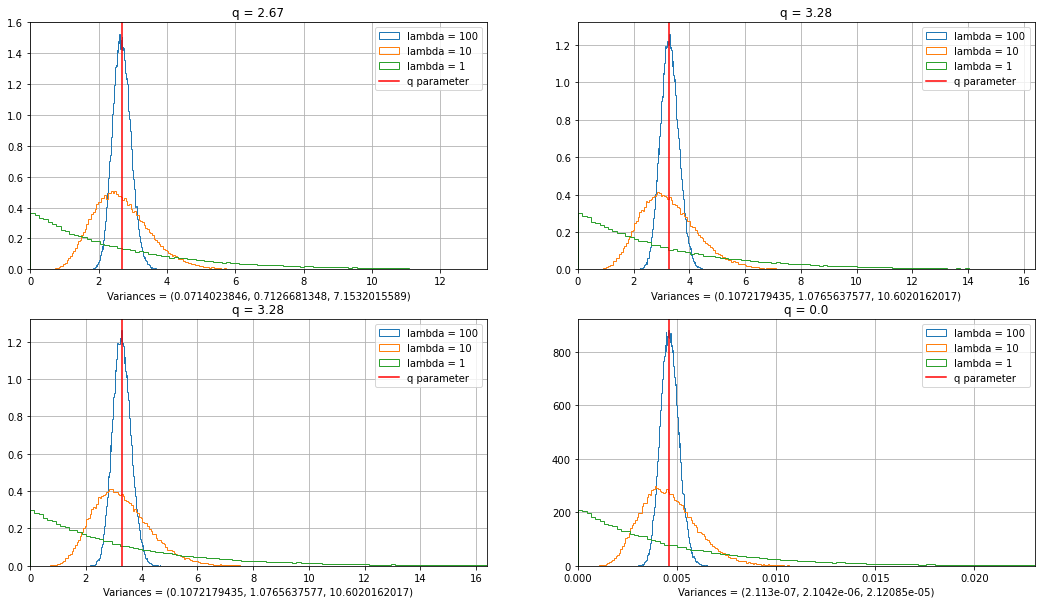

In [32]:
n = int(1e5)

lam1 = 100
alp = lam1
scale = x/lam1
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w1 = np.transpose(x_pr)

lam2 = 10
alp = lam2
scale = x/lam2
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w2 = np.transpose(x_pr)

lam3 = 1
alp = lam3
scale = x/lam3
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w3 = np.transpose(x_pr)

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=x[i+j], color = 'red', label = 'q parameter')
        axs[i,j].set_xlim([0,x[i+j]*5])
        axs[i,j].grid()
        axs[i,j].set_title(f'q = {np.round(np.mean(x[i+j]),2)}')
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
        axs[i,j].legend()
plt.show()
plt.close()

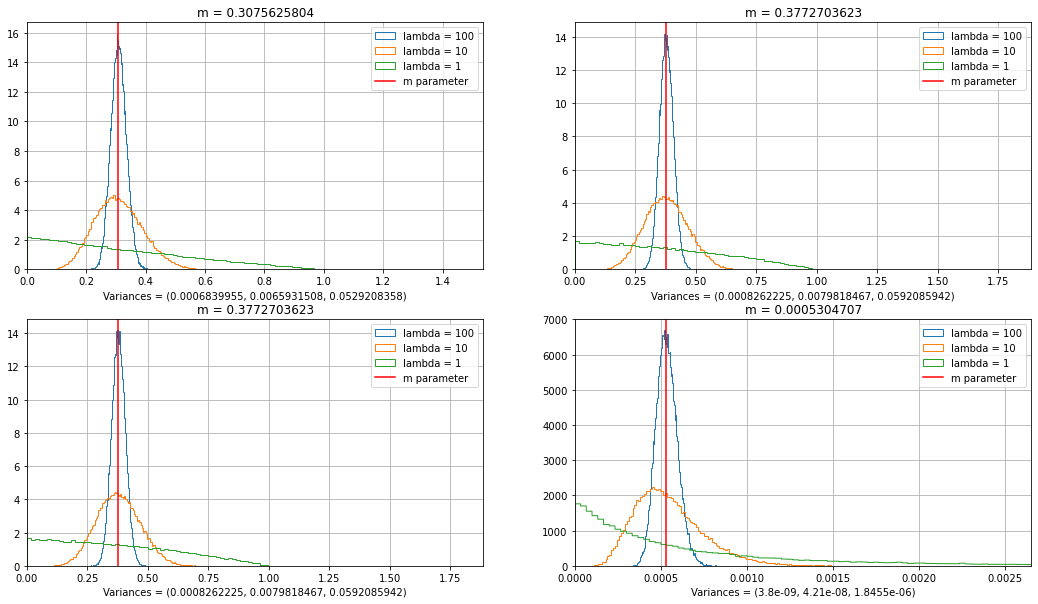

In [36]:
n = int(1e5)

lam1 = 100
alp = lam1
scale = x/lam1
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w1 = np.transpose(omega_pr)

lam2 = 10
alp = lam2
scale = x/lam2
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w2 = np.transpose(omega_pr)

lam3 = 1
alp = lam3
scale = x/lam3
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w3 = np.transpose(omega_pr)

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=omega[i+j], color = 'red', label = 'm parameter')
        axs[i,j].set_xlim([0,omega[i+j]*5])
        axs[i,j].grid()
        axs[i,j].set_title(f'm = {np.round(np.mean(omega[i+j]),10)}')
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
        axs[i,j].legend()
plt.show()
plt.close()

[0.00043598 0.00065941 0.00044799 ... 0.00057241 0.00050983 0.00048406]
[0.00046886 0.00058251 0.00034818 ... 0.00053508 0.00025735 0.00028331]
[1.65625094e-03 5.36715757e-04 5.10115153e-05 ... 3.14409240e-06
 6.71100711e-05 1.37617481e-05]


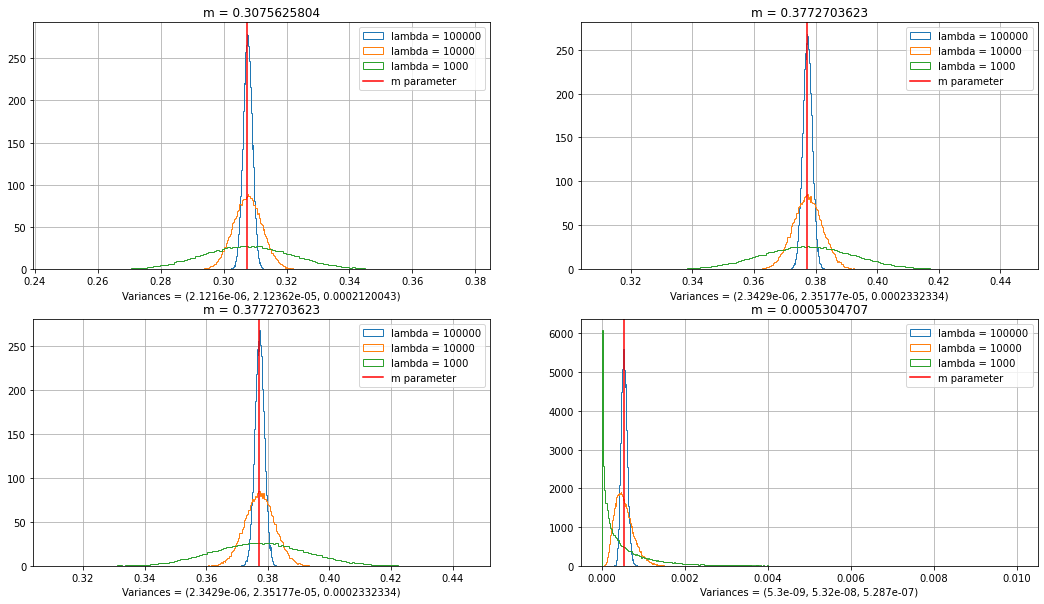

In [35]:
n = int(1e5)

lam1 = 100000
omega_pr = dirichlet.rvs(alpha=omega*lam1, size=n)
#print(omega_pr)
w1 = np.transpose(omega_pr)

lam2 = 10000
omega_pr = dirichlet.rvs(alpha=omega*lam2, size=n)
w2 = np.transpose(omega_pr)

lam3 = 1000
omega_pr = dirichlet.rvs(alpha=omega*lam3, size=n)
w3 = np.transpose(omega_pr)

print(w1[2])
print(w2[2])
print(w3[2])

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=omega[i+j], color = 'red', label = 'm parameter')
        #axs[i,j].set_xlim([0,1])
        axs[i,j].grid()
        axs[i,j].set_title(f'm = {np.round(np.mean(omega[i+j]),10)}')
        axs[i,j].legend()
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
plt.show()
plt.close()

In [ ]:
n_pars = 10
hm = 100
xt = generate_xt(n_pars, hm)
print(xt)

[[2.89974895e-01 1.33980800e-01 9.86655861e-02 3.59405318e-02
  1.28950810e-01 5.45313349e-02 1.05162379e-01 9.86624742e-02
  4.76645044e-02 6.46668328e-03]
 [7.30829242e-02 2.77996839e-01 1.94536855e-01 9.00999684e-02
  1.79219623e-01 2.09117602e-02 1.12057447e-01 1.60318426e-02
  2.65662738e-02 9.49646652e-03]
 [2.95336350e-01 2.64480447e-01 7.73753393e-02 5.07766110e-02
  6.56758011e-02 1.32799750e-01 2.90000482e-02 6.57721847e-02
  3.46515147e-04 1.84369534e-02]
 [2.37230681e-01 1.14861737e-01 2.31043289e-01 5.99625260e-02
  1.39546145e-01 6.62472690e-02 4.09561953e-02 6.85496519e-02
  3.57347616e-02 5.86774460e-03]
 [1.92765684e-01 7.93968011e-02 1.55938990e-01 2.17575214e-01
  6.37710345e-02 4.57039521e-02 1.17724235e-01 9.04065093e-02
  3.65470084e-02 1.70572100e-04]
 [1.67383304e-01 2.50049907e-01 1.32968433e-01 1.56608141e-01
  8.77636384e-02 4.75490570e-02 1.80355125e-02 8.47441082e-02
  4.26452181e-02 1.22526805e-02]
 [2.03095335e-01 2.58251191e-01 3.31066326e-02 2.08594950e

In [ ]:
a = 1
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)*a

n = int(1e5)
each = int(1e5)

In [ ]:
samples = sampling(n, xt, alpha, alpha_prop)

Acceptance rate 0.000830: 100%|██████████| 100000/100000 [02:04<00:00, 800.23it/s]


In [ ]:
eps2 = 0.5
samples2 = sampling2(n, xt, alpha, eps2, each)

Acceptance rate 0.327273:   0%|          | 72/100000 [00:00<02:36, 640.24it/s]

[ 6.33571644  7.9495295   9.88772238 13.85527641 13.17075169  3.58787084
  8.8096497   9.08508656  6.19380441 12.8305136 ]


Acceptance rate 0.194482: 100%|██████████| 100000/100000 [02:39<00:00, 628.50it/s]


In [ ]:
eps3 = 100
samples3 = sampling3(n, xt, alpha, eps3, each)

Acceptance rate 0.165605,    Skipped due to zero in some omega proposed 0.000000:   0%|          | 86/100000 [00:00<01:56, 858.90it/s]

[0.05218539 0.02886763 0.06947693 0.15005688 0.38701564 0.06831175
 0.04596699 0.1322527  0.01883707 0.04702901]


Acceptance rate 0.089431,    Skipped due to zero in some omega proposed 0.000910: 100%|██████████| 100000/100000 [01:50<00:00, 905.59it/s]


In [ ]:
eps5 = 1e3
samples5 = sampling5(n, xt, alpha, eps5, each)

Acceptance rate 0.000000:   0%|          | 60/100000 [00:00<02:49, 590.53it/s]

[212.71409101 111.41463575  50.38765902  83.28149245  99.90444004
  64.88881899  14.51861992  48.47384755  93.9256435  189.3622734 ]


Acceptance rate 0.000000:   4%|▎         | 3583/100000 [00:05<02:28, 649.54it/s]


KeyboardInterrupt: 

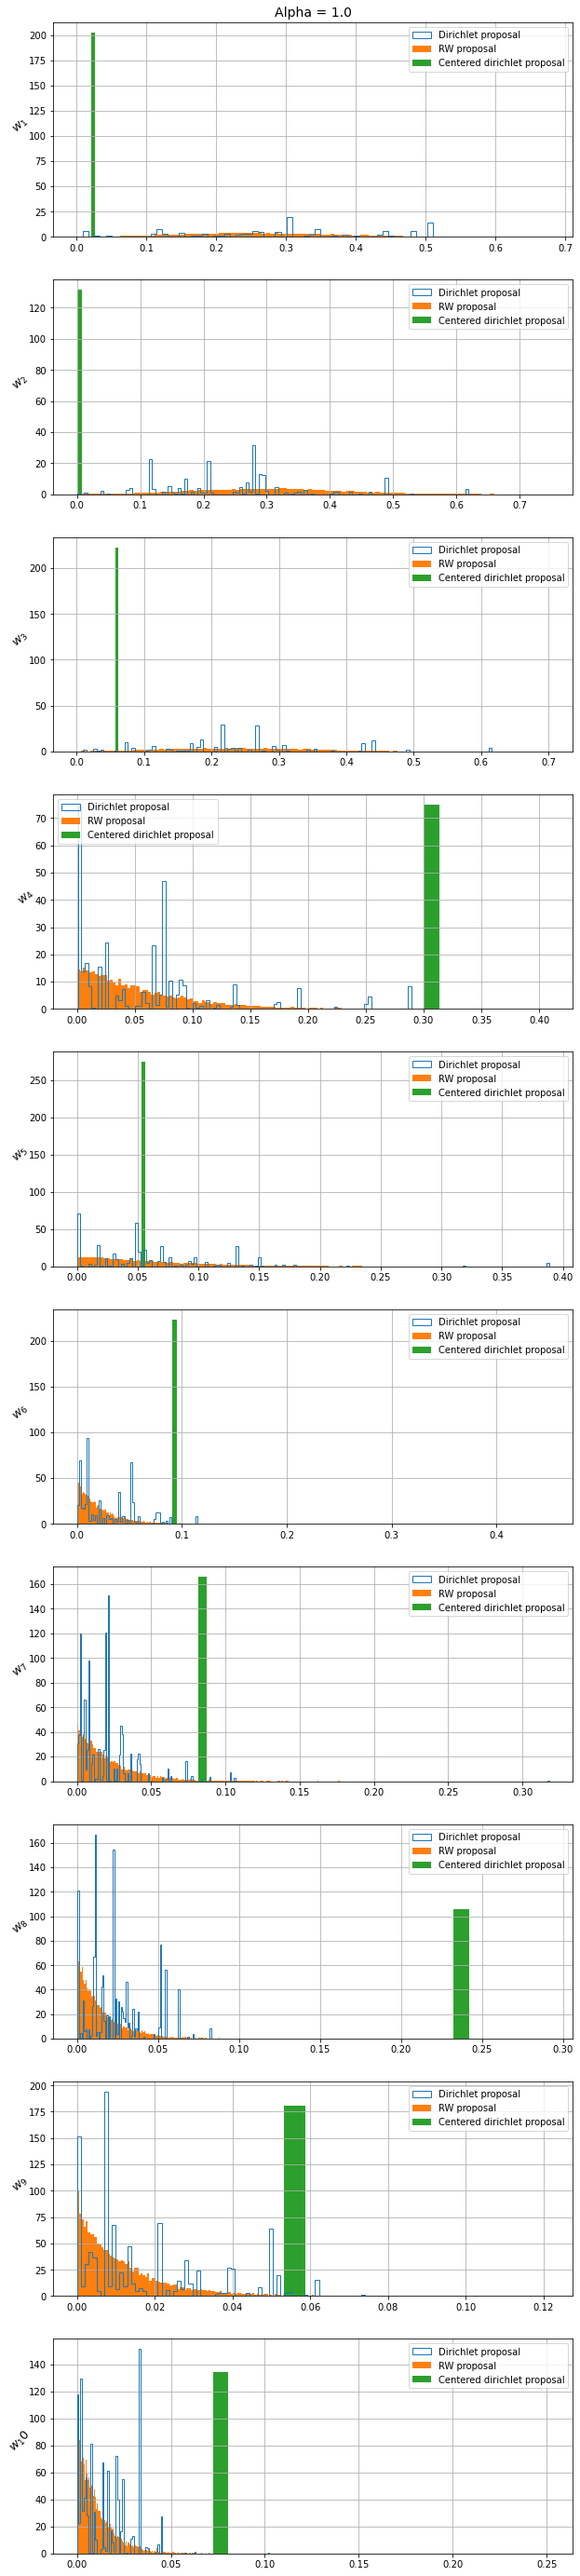

In [ ]:
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w = samples
w2 = samples2
w3 = samples5
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].hist(np.transpose(w3)[i], bins = 'auto', density = True, label = 'Centered dirichlet proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    #axs[i].set_ylim([0,100])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

In [ ]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples)
smp2 = np.transpose(samples2)
smp3 = np.transpose(samples3)
nn = len(samples)
cors = np.zeros((n_pars,nn))
cors2 = np.zeros((n_pars,nn))
cors3 = np.zeros((n_pars,len(samples3)))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample1')
    cors2[i] = autocorr_func_1d(smp2[i], norm=True)
    axs[i].scatter(x, cors2[i], label = 'Numerical covariance Sample2')
    cors3[i] = autocorr_func_1d(smp3[i], norm=True)
    axs[i].scatter(np.arange(0, len(samples3)), cors3[i], label = 'Numerical covariance Sample3')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)

NameError: name 'samples3' is not defined

100%|██████████| 10/10 [00:00<00:00, 54.43it/s]


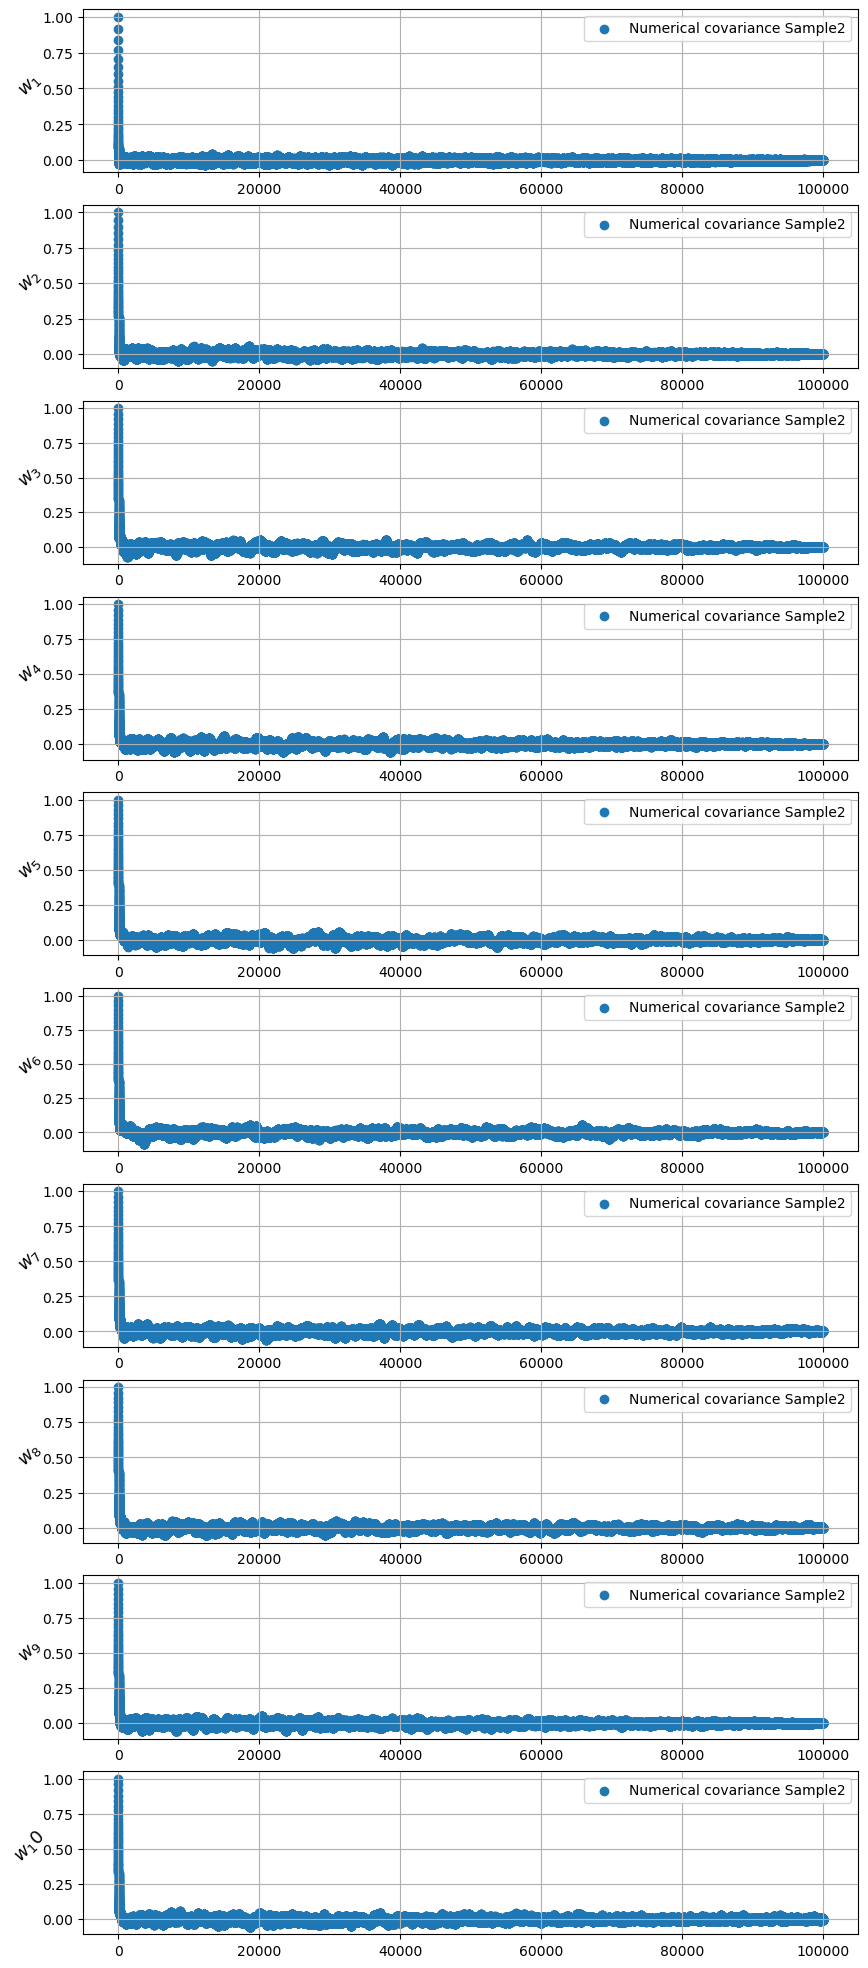

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [ ]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples2)
nn = len(samples2)
cors = np.zeros((n_pars,nn))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample2')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)